Windowing Method: Introduction
--------------

In this section, we start designing FIR filters using the windowing design method. This is the most straightforward design method and it will illustrate the concepts we  developed in the previous section.

This notebook has been taken from https://github.com/unpingco/Python-for-signal-Processing/blob/master/Filtering_Part2.ipynb


### Ideal and Truncated (Windowed) Lowpass Filter 

The window method of FIR filter design starts by constructing the ideal filter response, $ H_d(\omega) $. For example, consider the ideal lowpass filter,

$$ |H_d(\omega)| =1 \forall \omega \in (-\omega_c,\omega_c) $$

and zero otherwise. The  inverse Fourier transform is the sequence,

$$ h_n = \frac{\omega_c}{\pi}\frac{\sin (\omega_c n )}{\omega_c n} $$

if $ n \neq 0 $ and 

$$ h_{n=0} = \frac{\omega_c}{\pi} $$

This is obviously non-causal and infinitely long. We can shift the sequence by an arbitrary amount and then truncate to fix both problems, respectively.


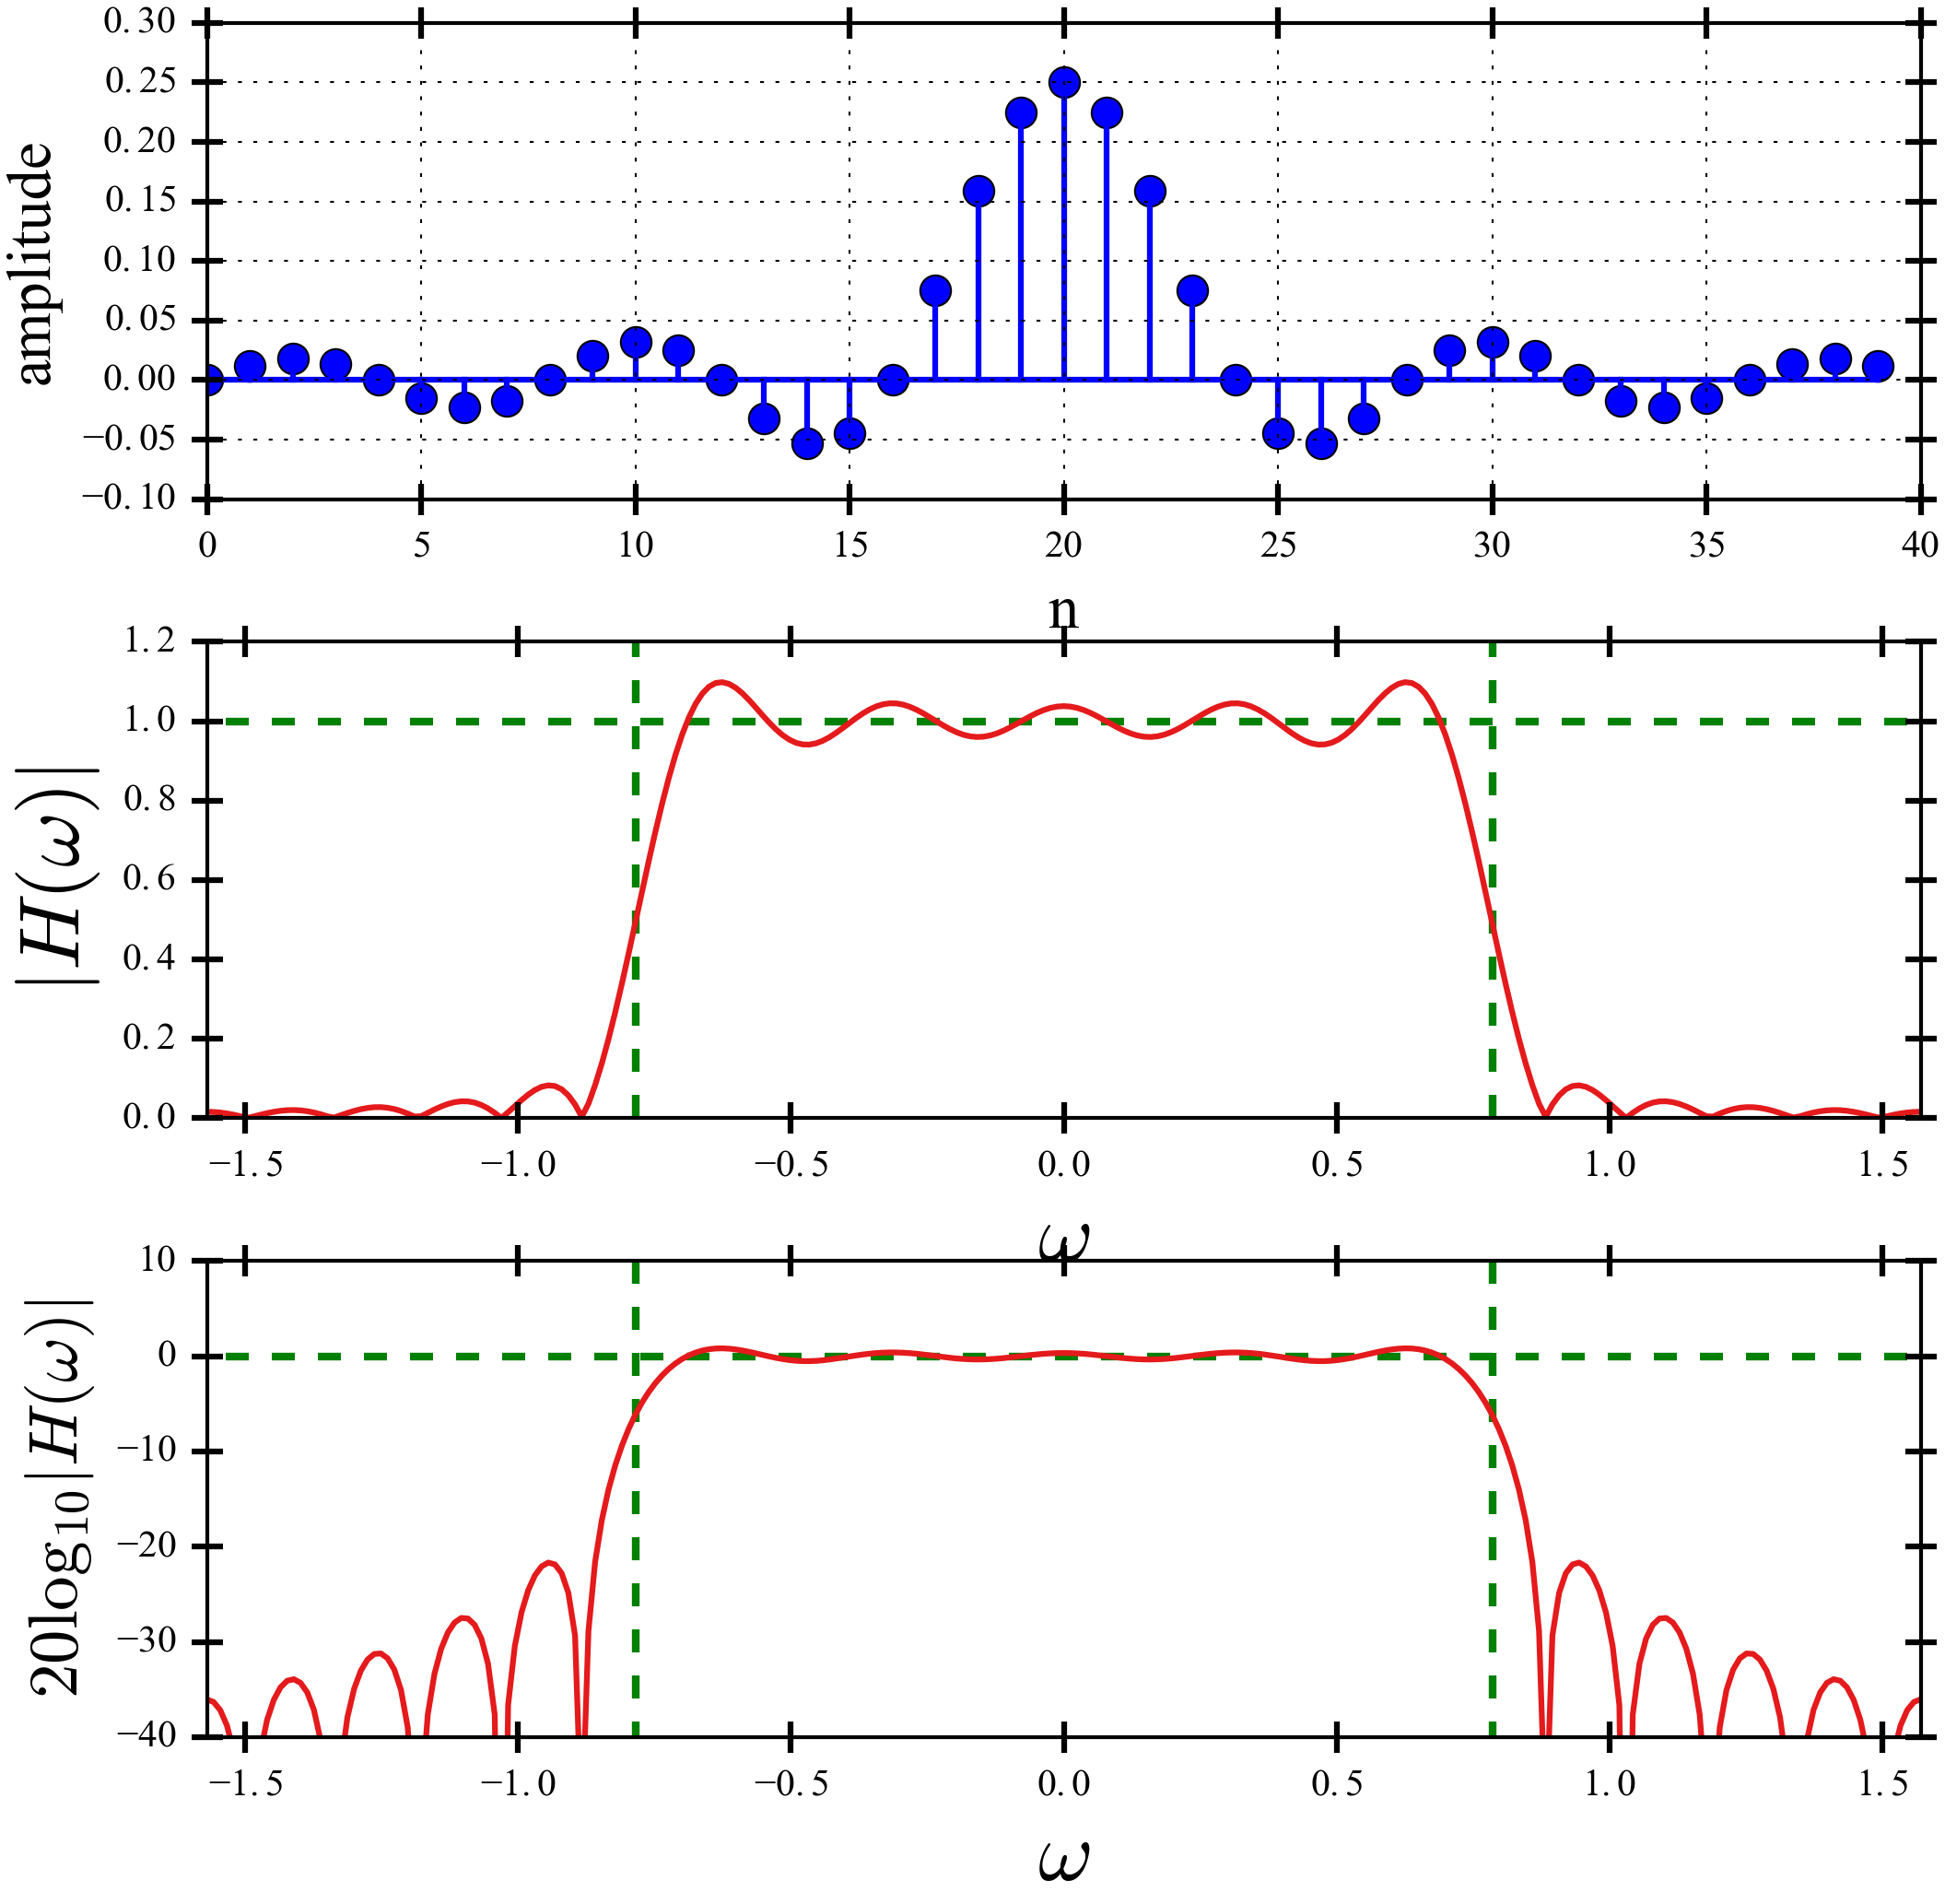

In [1]:
# omega_c = pi/4

from __future__ import division
from numpy import angle, arange, cos, fft, linspace, log10, pi, ones, sin, sinc
import scipy.signal as sig
#import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, subplot, subplots, subplots_adjust, show
%matplotlib inline

wc = pi/4
M = 20
N = 512 # DFT size
n = arange(-M,M)
h = wc/pi * sinc(wc*(n) / pi)  # see definition of np.sinc()

w,Hh = sig.freqz(h, 1, whole=True, worN=N) # get entire frequency domain
wx = fft.fftfreq(len(w)) # shift to center for plotting

fig, axs = subplots(3, 1)
fig.set_size_inches((8, 8))
subplots_adjust(hspace=0.3)

ax = axs[0]
ax.stem(n+M, h, basefmt='b-')
ax.set_xlabel("n", fontsize=16)
ax.set_ylabel("amplitude", fontsize=16)

ax = axs[1]
ax.plot(w-pi,abs(fft.fftshift(Hh)))
ax.axis(xmax=pi/2,xmin=-pi/2)
ax.vlines([-wc, wc], 0, 1.2, color='g', lw=2., linestyle='--',)
ax.hlines(1, -pi, pi, color='g', lw=2., linestyle='--',)
ax.set_xlabel(r"$\omega$", fontsize=22)
ax.set_ylabel(r"$|H(\omega)| $", fontsize=22)
ax.grid()

ax = axs[2]
ax.plot(w-pi, 20*log10(abs(fft.fftshift(Hh))))
ax.axis(ymin=-40, xmax=pi/2, xmin=-pi/2)
ax.vlines([-wc,wc], 10, -40, color='g', lw=2., linestyle='--',)
ax.hlines(0, -pi, pi, color='g', lw=2., linestyle='--',)
ax.grid()
ax.set_xlabel(r"$\omega$", fontsize=22)
ax.set_ylabel(r"$20\log_{10}|H(\omega)| $", fontsize=18);
#ax.axis( ymin=-40,xmax=pi/2)

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


The figure above shows the filter sequence $ h_n $ in the top plot. This has been shifted over to enforce causality. The middle plot shows $ |H(\omega)| $ as a function of frequency. The vertical green lines show $ \pm\omega_c $ limits and the horizontal green line shows the ideal response, $ |H_d(\omega)| $. The bottom plot shows $ 20\log_{10} |H(\omega)| $ as a function of frequency. The middle plot reveals  rippling in the passband that increases towards the edge of the passband. This is known as the *Gibbs phenomenon* and we need to examine it carefully because it is a serious form of distortion. 

Truncating the filter coefficients is the same as multiplying the infinitely-long desired filter sequence ($ h_{d} $) by a rectangular window ($ w_n $); this is equivalent to a convolution in the frequency domain between  the desired reponse, $ H_d(\omega) $, and $ W(\omega)$, the Fourier transform of the rectangular window. Thus, the filter output is

$$ Y(\omega)  = \frac{1}{2\pi}\int_{-\pi}^{\pi} H_d(\xi) W(\omega-\xi) d\xi = \frac{1}{2\pi}\int_{-\omega_c}^{\omega_c}W(\omega-\xi) d\xi$$

where 

$$ W(\omega)=\sum_{n=0}^{N_s-1} \exp \left( -j\omega n \right) $$

Because everything is finite, we can combine these   two equations to  obtain the following:

$$ Y(\omega) = \frac{1}{2\pi}\sum_{n=0}^{N_s-1}\int_{-\omega_c}^{\omega_c} \exp \left( -j(\omega-\xi) n \right) d\xi =\frac{1}{\pi}\sum_{n=0}^{N_s-1}\frac{\sin(n\omega_c)}{n} \hspace{1em}\exp(j\omega n) $$ 

We can expand the summation term to obtain,

$$ Y(\omega) = \frac{1}{\pi}\sum_{n=0}^{N_s-1}\frac{\cos(n\omega)\sin(n\omega_c)+j\sin(n\omega)\sin(n\omega_c)}{n} $$ 

To understand the Gibbs phenomenon at the edges where $ \omega=\omega_c $, we recall the following two trigonometric identities:

$$ 2\cos(n\omega)\sin(n\omega_c)= \sin(n\omega+n\omega_c)-\sin(n\omega-n\omega_c) $$

and likewise,

$$ 2\sin(n\omega)\sin(n\omega_c)= \cos(n\omega-n\omega_c)-\cos(n\omega+n\omega_c) $$

These two identities show that as $ \omega \rightarrow \omega_c $, the surviving terms in $ Y(\omega) $ summation oscillate at double the cut-off frequency (i.e $ 2\omega_c $) which accounts for the intense rippling effect as $ \omega $ moves from $ \omega=0 $ to $\omega=\omega_c$. Consider the real part of $ Y(\omega) $ when $ \omega \lt \omega_c $,

$$ Y_{re}(\omega) = \frac{1}{\pi}\sum_{n=0}^{N_s-1}\frac{\sin(n\omega+n\omega_c)-\sin(n\omega-n\omega_c)}{2 n} $$ 


In this case, $ \sin(n\omega-n\omega_c) \lt 0 $ so it contributes positively (i.e. constructive interference) to the summation. When $\omega \gt \omega_c  $, the sign  reverses and destructive interference reduces the real part. This is the mechanism that characterizes the transition from the passband to the stopband.

The following figure illustrates this effect.

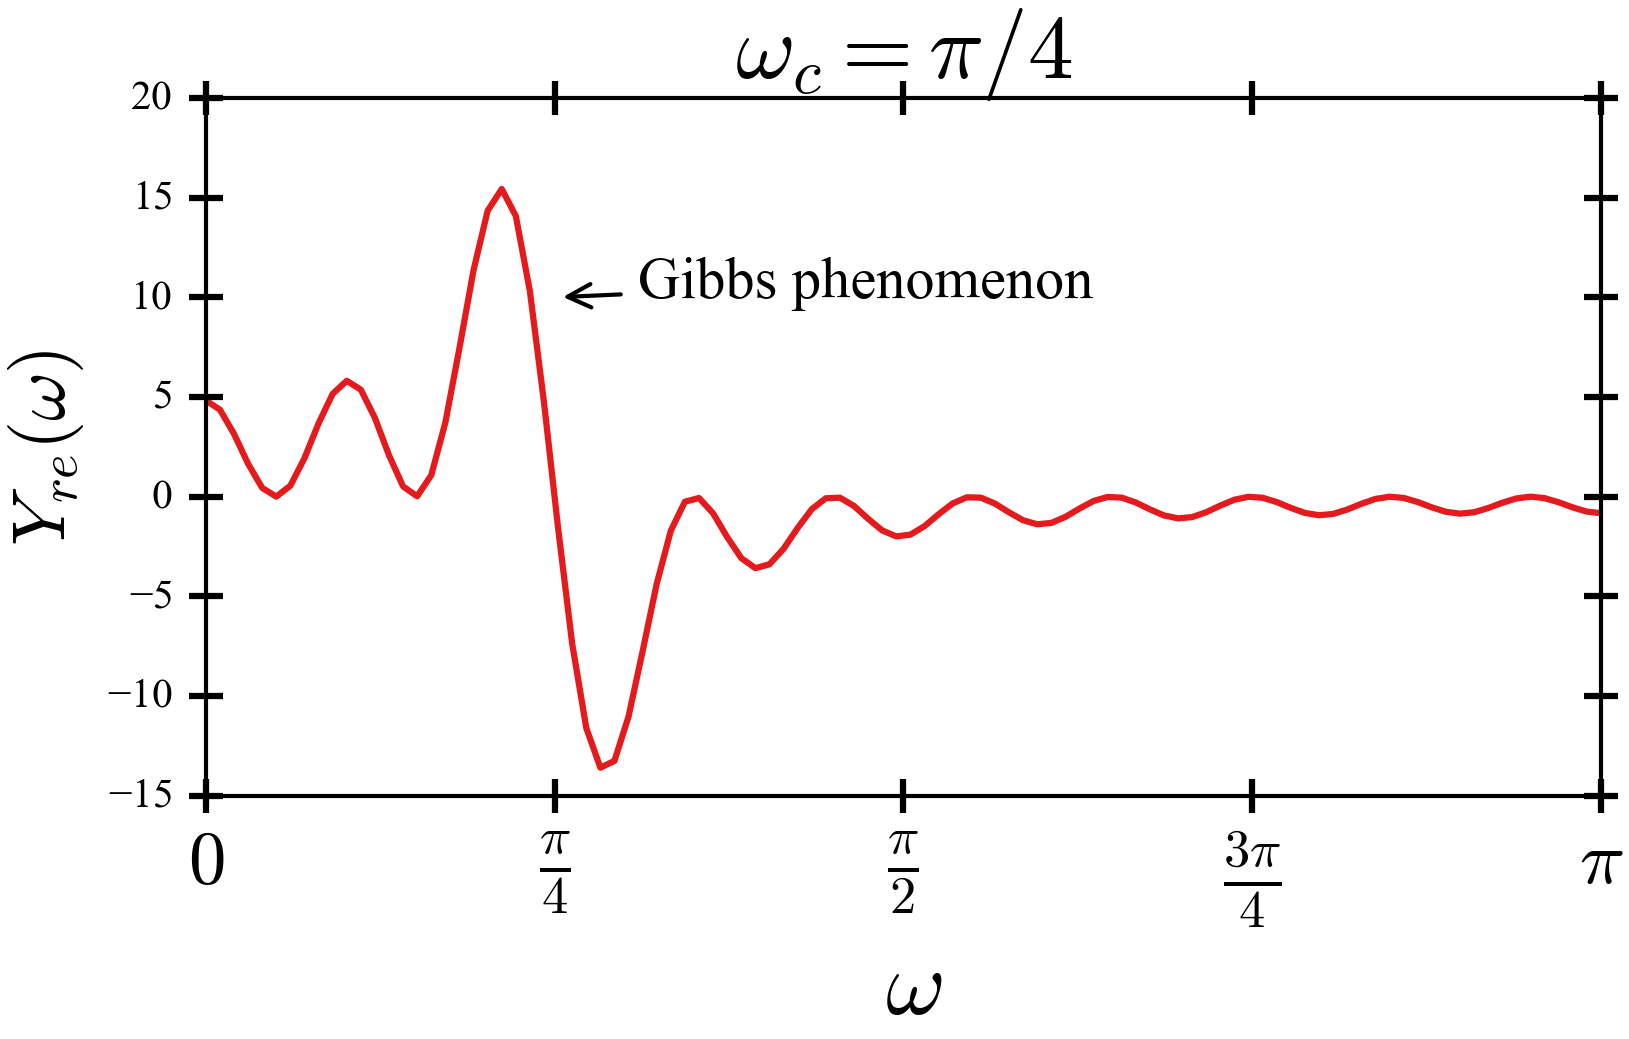

In [2]:
fig,ax = subplots()
fig.set_size_inches(6, 3)

k = arange(M)
omega = linspace(0, pi, 100)

ax.plot(omega, (sin(k*omega[:, None]+k*wc) - sin(k*omega[:, None]-k*wc)).sum(axis=1))
ax.set_ylabel(r"$Y_{re}(\omega)$", fontsize=18)
ax.grid()
ax.set_title(r"$\omega_c = \pi/4$", fontsize=22)
ax.set_xlabel(r" $\omega $", fontsize=22)
ax.set_xticks([0, pi/4, pi/2., 3*pi/4, pi,])
ax.set_xticklabels(['$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'], fontsize=18)
ax.set_xlim(xmax=pi)
ax.annotate("Gibbs phenomenon", xy=(pi/4,10), fontsize=14,
            xytext=(20, 0),
            textcoords='offset points',
            arrowprops={'facecolor':'b','arrowstyle':'->'});

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


Now that we have a grip on the the Gibbs phenomenon, we need to control this form of distortion. Fortunately, we already have all of the tools in place from our prior discussion of window functions.

## Using Windows for FIR Filter Design

The root of the Gibbs phenomenon is the sudden truncation of the filter sequence by the rectangular window. We can mitigate this effect by  smoothly  guiding the filter coefficients to zero using a window function.  The following figure is the same as before but now we use a Hamming window to terminate the ideal filter sequence.

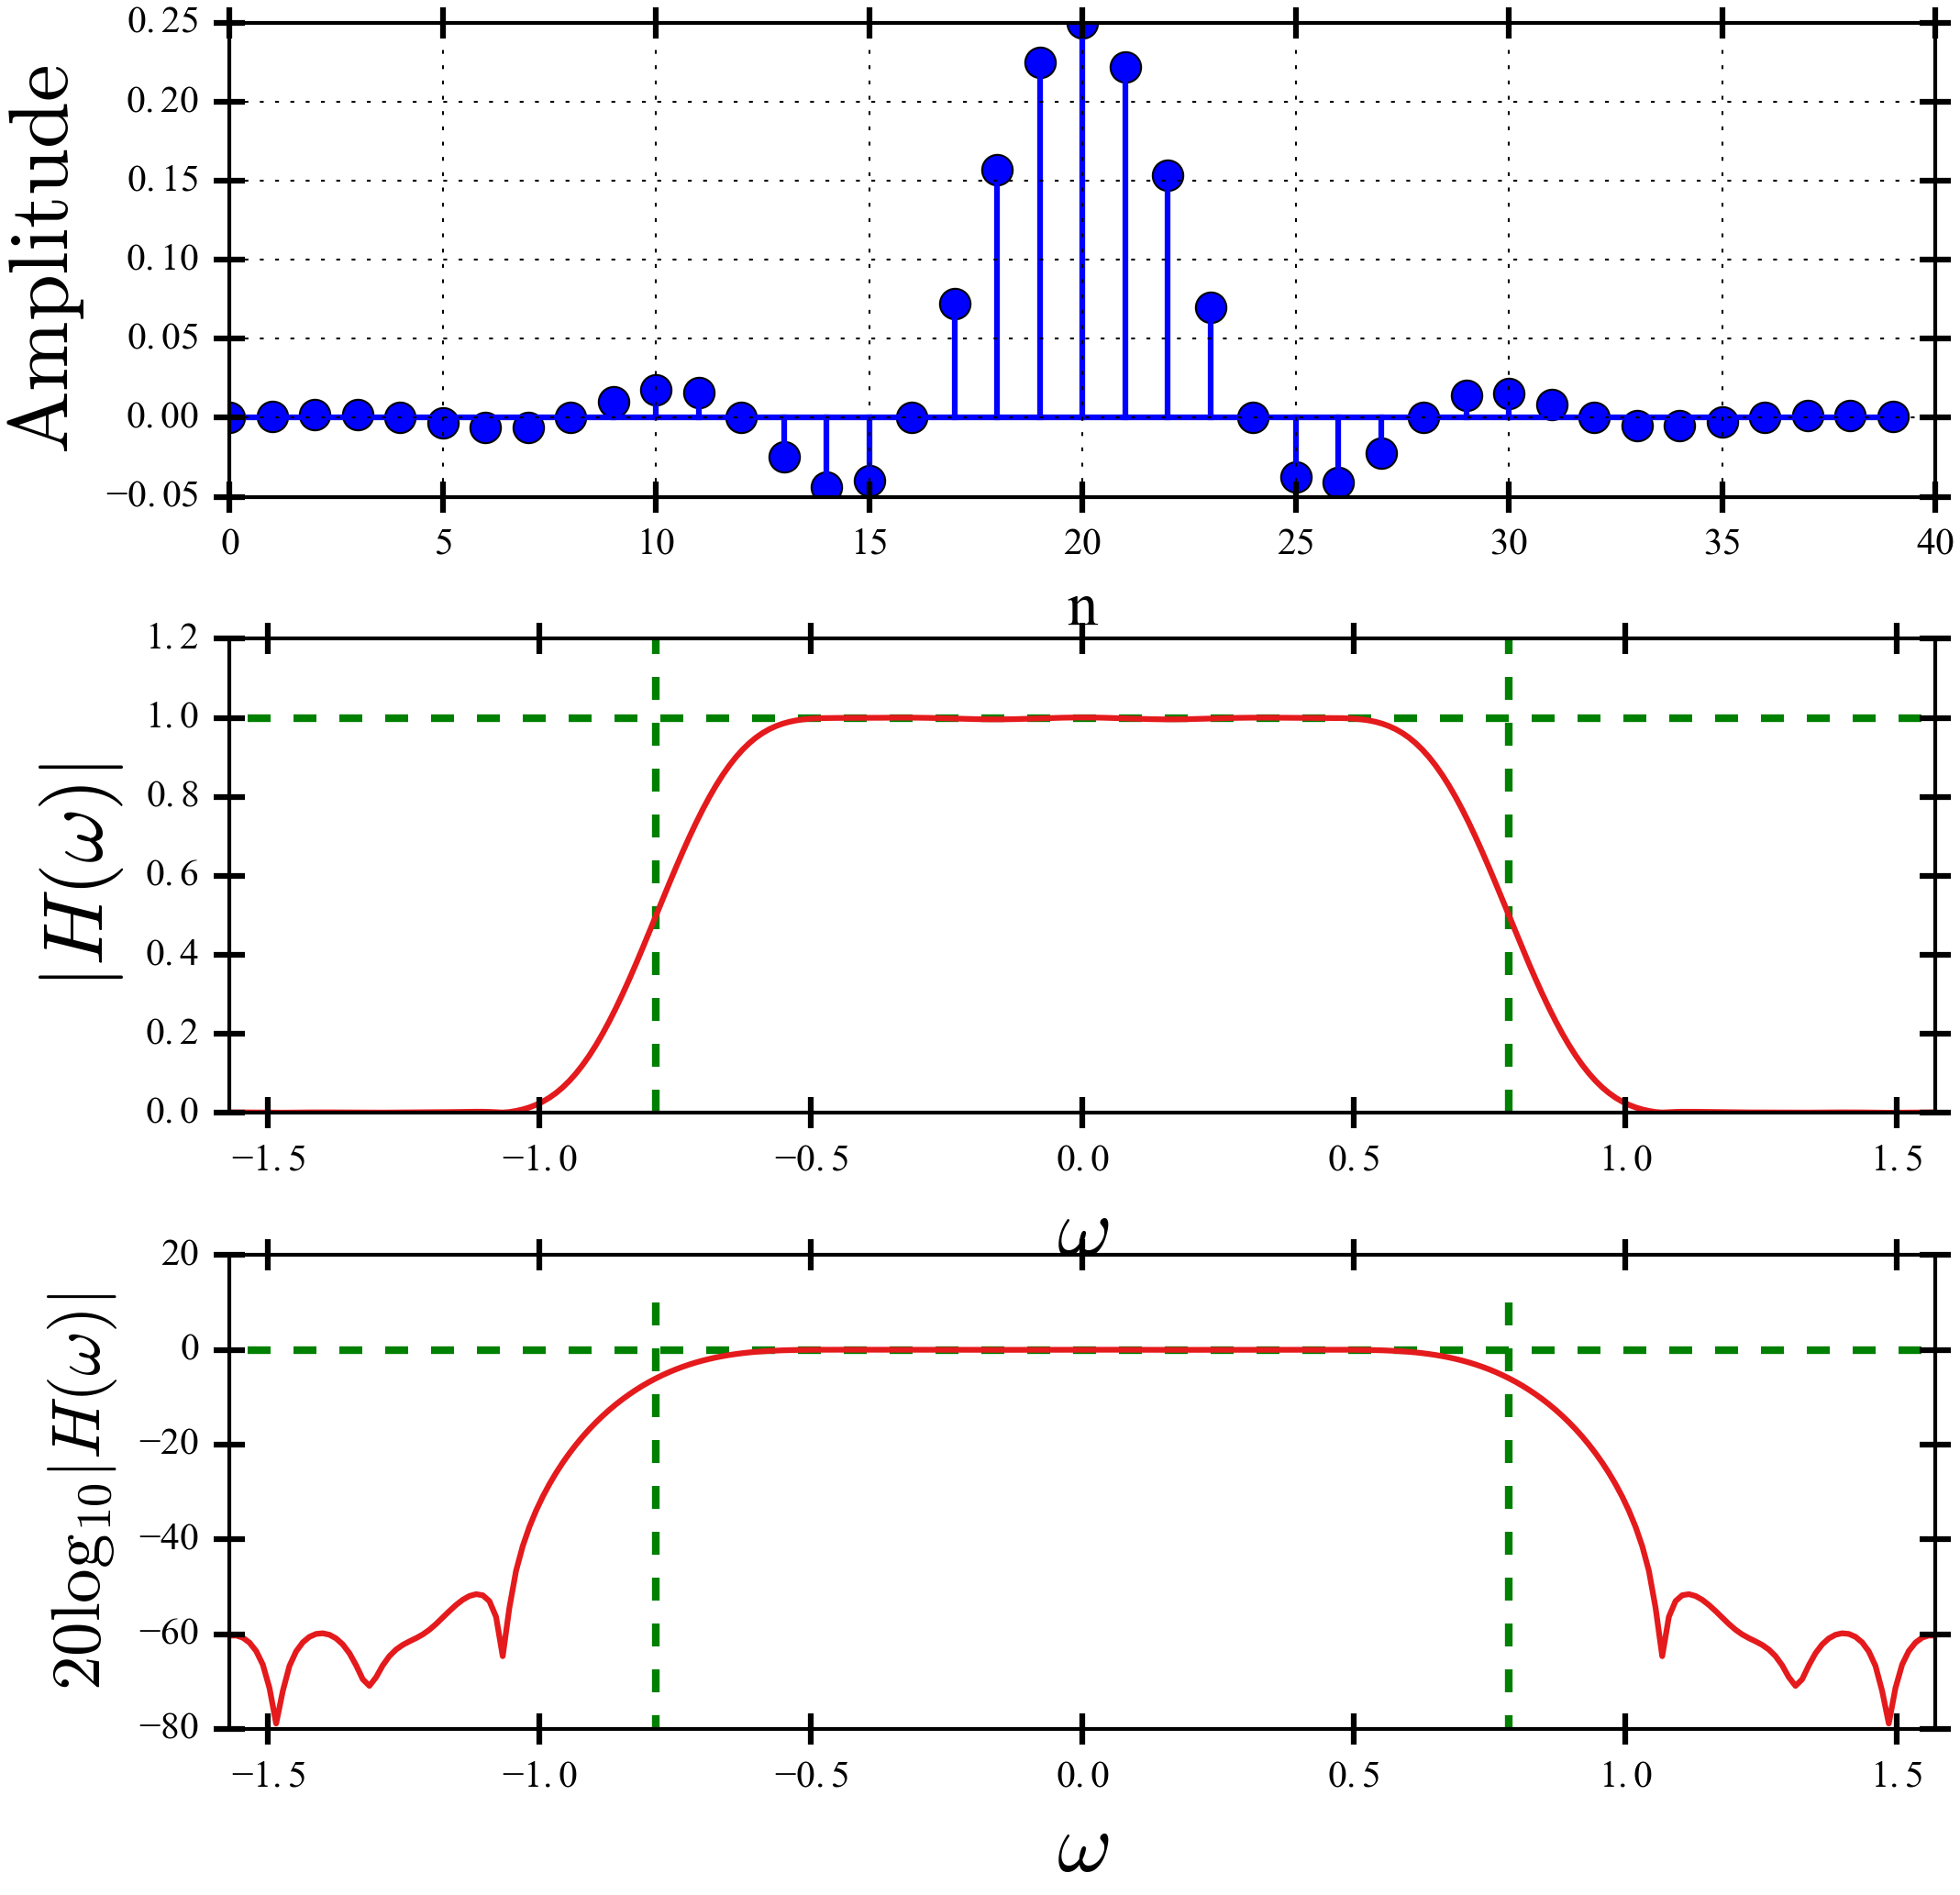

In [3]:
wc = pi/4

M = 20

N = 512 # DFT size
n = arange(-M,M)
win = sig.hamming(len(n))
h = wc/pi * sinc(wc*(n)/pi)*win  # see definition of np.sinc()

w,Hh = sig.freqz(h, 1, whole=True, worN=N) # get entire frequency domain
wx = fft.fftfreq(len(w)) # shift to center for plotting

fig, axs = subplots(3, 1)
fig.set_size_inches((8, 8))
subplots_adjust(hspace=0.3)

ax=axs[0]
ax.stem(n+M, h, basefmt='b-')
ax.set_xlabel("n", fontsize=16)
ax.set_ylabel(r"$\mathrm{Amplitude}$", fontsize=22)

ax = axs[1]
ax.plot(w-pi, abs(fft.fftshift(Hh)))
ax.axis(xmax=pi/2, xmin=-pi/2)
ax.vlines([-wc,wc], 0, 1.2, color='g', lw=2., linestyle='--',)
ax.hlines(1, -pi, pi, color='g', lw=2., linestyle='--',)
ax.set_xlabel(r"$\omega$", fontsize=22)
ax.set_ylabel(r"$|H(\omega)| $", fontsize=22)
ax.grid()

ax = axs[2]
ax.plot(w-pi, 20*log10(abs(fft.fftshift(Hh))))
ax.axis(ymin=-80, xmax=pi/2, xmin=-pi/2)
ax.vlines([-wc,wc], 10, -80, color='g', lw=2., linestyle='--',)
ax.hlines(0, -pi, pi, color='g', lw=2., linestyle='--',)
ax.grid()
ax.set_xlabel(r"$\omega$",fontsize=22)
ax.set_ylabel(r"$20\log_{10}|H(\omega)| $",fontsize=18);
#ax.axis( ymin=-40,xmax=pi/2)

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)



The figure above shows the frequency response using a Hamming window to gently terminate  the filter sequence. Note that the Gibbs effect is significantly reduced, producing a much flatter mainlobe at the cost of a wider mainlobe. The mainlobe widens because the mainlobe of the Hamming window is wider than that of the rectangular window. The much lower sidelobes of   the Hamming window flattens the Gibbs phenomenon at the edge of the passband.

I invite you to download the IPython notebook corresponding to this post and try the above for different values of $ M $. Note that drop from the passband to the sidelobes steepens with increasing $ M $. As we have seen before with window functions, this is because the window's mainlobe narrows with increasing sequence length. Naturally, you can use other window functions besides Hamming and change the sidelobe level and mainlobe width. The most popular window used for this method of filter design is the Kaiser-Bessel window because it provides extra parameters for tuning the frequency response.

Let's consider a design example using Kaiser-Bessel and the filter design tools in the `sig.fir_filter_design` module.

The `sig.fir_filter_design` module provides functions for filter design using the Kaiser-Bessel window ( among other windows). For example, to design a lowpass filter using the  Kaiser-Bessel window, we need the a subset of the following parameters: maximum passband ripple ($ \delta $), width of the transition region,  Kaiser-Bessel parameter $\beta$, and the number of filter taps. The `fir_filter_design` provides tools to solve for some of these parameters given others. For example, the `fir_filter_design.kaiserord()` function  can determine the number of taps given the maximum allowable passband ripple and the width of the transition region. 

Consider the following low pass filter specification.

In [4]:
Ns = 300 # number of samples 
N = 1024 # DFT size

fs = 1e3 # sample rate in Hz
fpass = 100 # in Hz
fstop = 150 # in Hz
delta = 60 # in dB, desired attenuation in stopband

Now, we need to determine the number of tabs and the  Kaiser-Bessel $ \beta $ parameter using the `fir_filter_design.kaiserord()` function as shown below.  For the FIR window design method, the $ \delta $ parameter is simultaneously the maximum allowable passband ripple and the desired attenuation in the stopband.

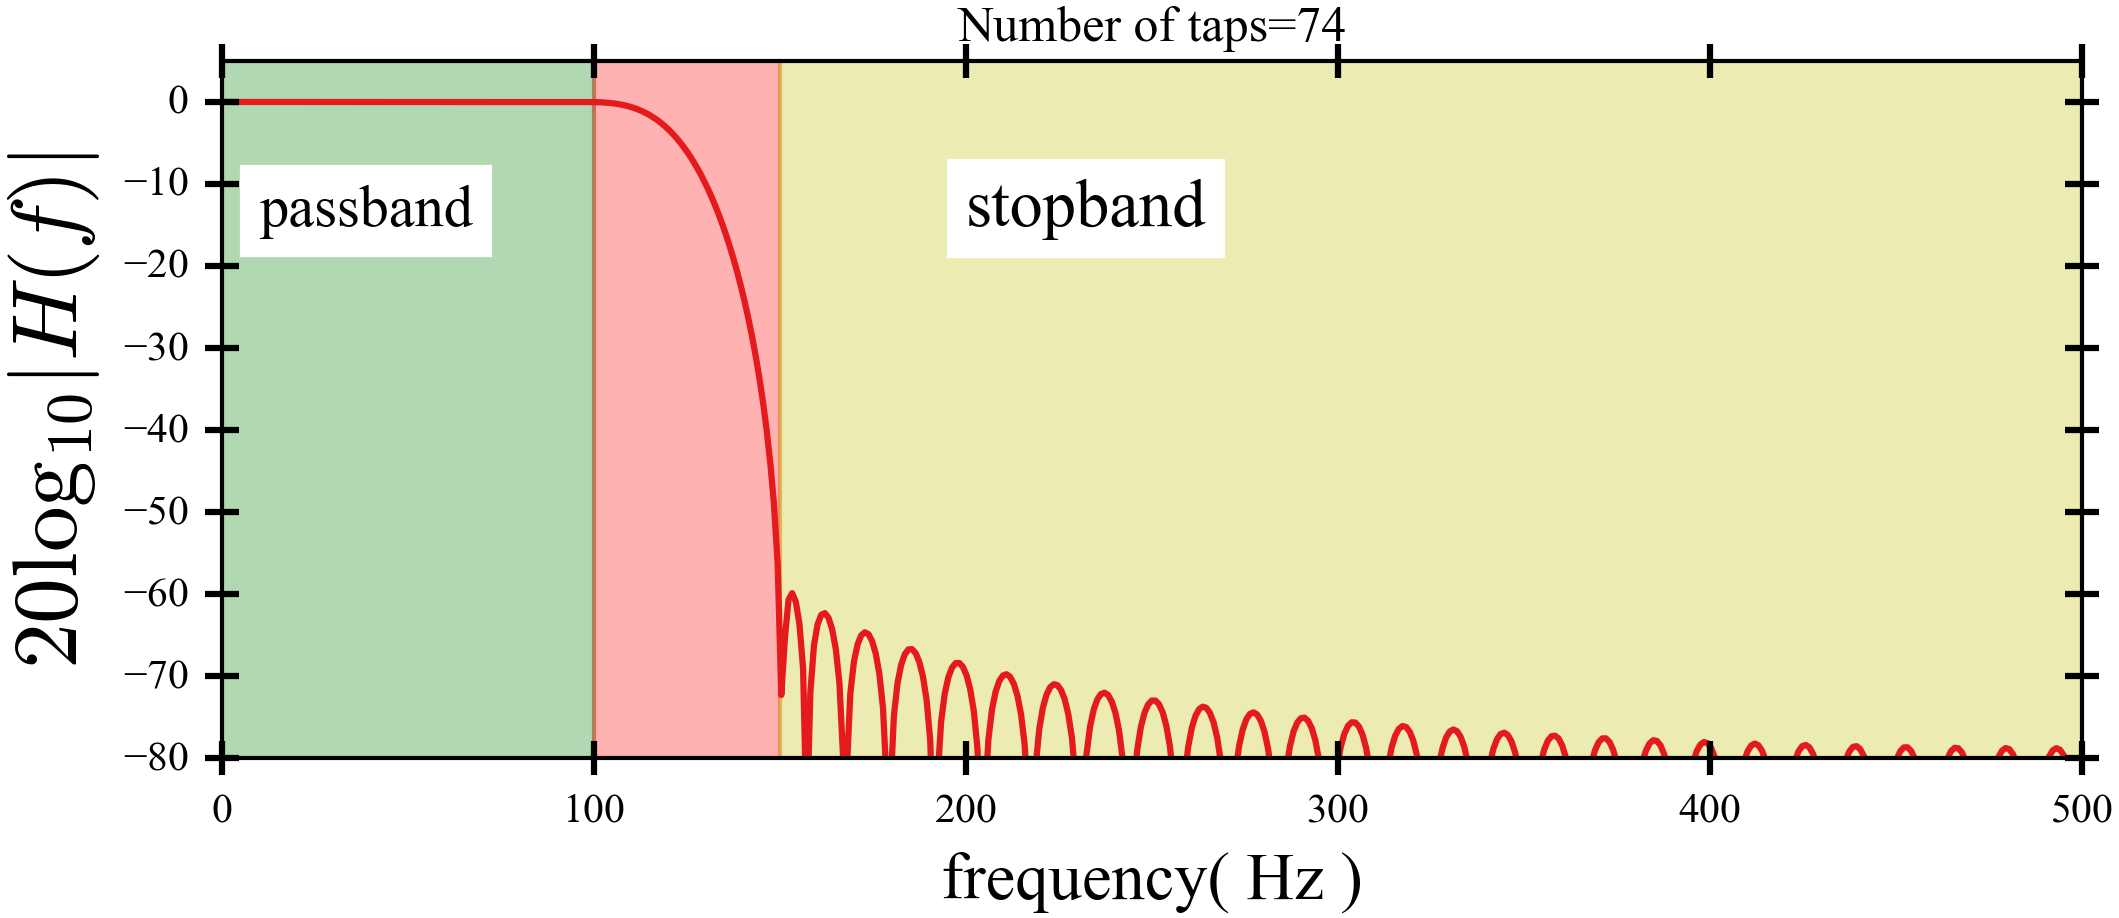

In [5]:
from matplotlib.patches import Rectangle

M,beta = sig.fir_filter_design.kaiserord(delta, (fstop-fpass)/(fs/2.))

hn = sig.firwin(M,(fstop+fpass)/2.,window=('kaiser',beta),nyq=fs/2.)
w,H = sig.freqz(hn) # frequency response

fig,ax = subplots()
fig.set_size_inches((8,3))

ax.plot(w/pi*fs/2.,20*log10(abs(H)))
ax.set_xlabel("frequency( Hz )",fontsize=16)
ax.set_ylabel(r"$20\log_{10} |H(f)| $",fontsize=22)
ymin,ymax = -80,5
ax.axis(ymin = ymin,ymax=ymax)
ax.add_patch(Rectangle((0,ymin),width=fpass,height=ymax-ymin,color='g',alpha=0.3))
ax.add_patch(Rectangle((fpass,ymin),width=fstop-fpass,height=ymax-ymin,color='r',alpha=0.3))
ax.add_patch(Rectangle((fstop,ymin),width=fs/2-fstop,height=ymax-ymin,color='y',alpha=0.3))
ax.set_title("Number of taps=%d"%M)
ax.text(10,-15,'passband',fontsize=14,bbox=dict(color='white'))
ax.text(200,-15,'stopband',fontsize=16,bbox=dict(color='white'))
ax.grid()

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


### Example

In the following, let's consider the performance of the filter with two equal-amplitude single-frequency tones, one in the passband and one in the stopband.

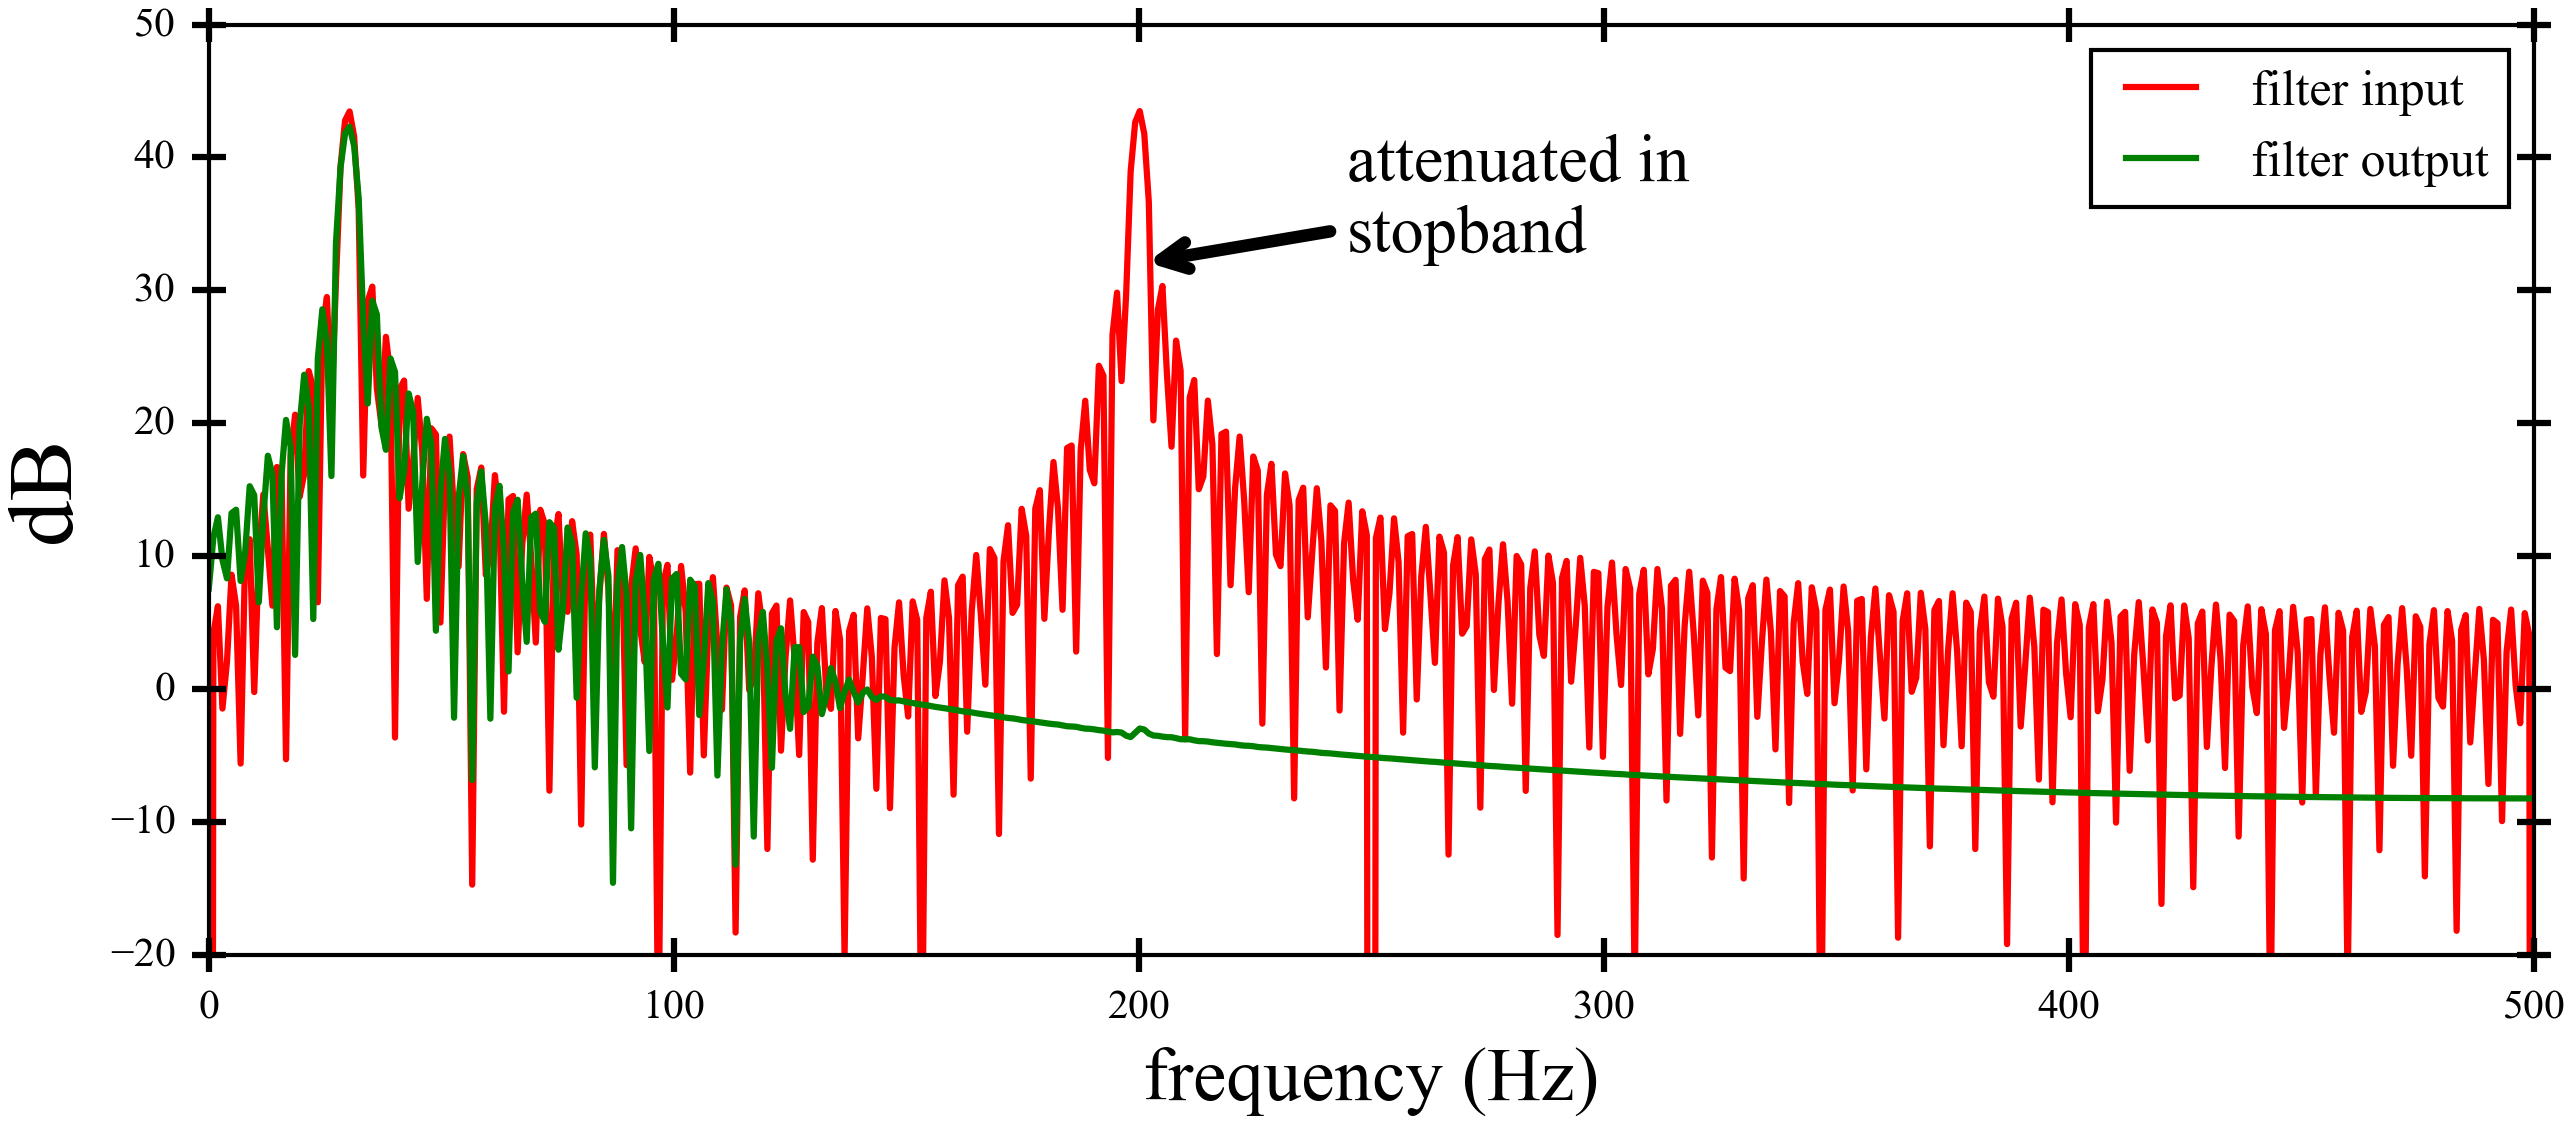

In [6]:
# two-tone example using filter

t = arange(0,Ns)/fs
x = cos(2*pi*30*t)+cos(2*pi*200*t)
X = fft.fft(x,N)

y=sig.lfilter(hn,1,x)
Y = fft.fft(y,N)

fig,ax = subplots()
fig.set_size_inches((10,4))
ax.plot(arange(N)/N*fs,20*log10(abs(X)),'r-',label='filter input')
ax.plot(arange(N)/N*fs,20*log10(abs(Y)),'g-',label='filter output')
ax.set_xlim(xmax = fs/2)
ax.set_ylim(ymin=-20)
ax.set_ylabel(r'dB',fontsize=22)
ax.set_xlabel("frequency (Hz)",fontsize=18)
ax.grid()
ax.annotate('attenuated in\nstopband',fontsize=16,xy=(200,32),
             xytext=(50,3),textcoords='offset points',
             arrowprops=dict(arrowstyle='->',lw=3),
            )
ax.legend(loc=0);

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


The figure above shows the frequency domain input and the corresponding filtered output. Because second tone is in the stopband, and its relative energy is approximately 40 dB, it is completely extinguished by the filter, whose attenuation in the stopband is 60 dB. I invite you to download the IPython Notebook corresponding to this section and try different amplitude values for the tone in the stopband.

## Summary

The window design method is the easiest FIR design method to understand and it draws upon intuitions regarding window function that we have previously developed. The Kaiser-Bessel method is widely used because it provides design flexibility and easy-to-understand filter  specifications. Furthermore, there are many closed form approximations to the various derived terms (e.g. $ \beta $, $ M $) which means that time-consuming iterative algorithms are not necessary and that engineering trade-offs appear explicitly in a formula.

In the next section we consider Parks-McClellan  FIR design that solves for the desired filter sequence using a powerful iterative exchange algorithm that generally  results in filters with fewer taps for the same level of performance.

References
---------------

* Proakis, John G. ,*Digital signal processing: principles algorithms and applications*. Pearson Education India, 2001.

* Oppenheim, Schafer, "Discrete-Time signal Processing", p.475-476.

* Original from [here](https://github.com/unpingco/Python-for-signal-Processing/blob/master/Filtering_Part2.ipynb). 